In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
!pip install -q kaggle

In [3]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
# Generators for loading large dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)
test_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [7]:
# Normalizing the images
def process(image,label):
  image=tf.cast(image/255. , tf.float32)
  return image,label
train_ds = train_ds.map(process)
test_ds = test_ds.map(process)

In [8]:
# Creating custom CNN Model
model = Sequential()

model.add((Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3))))
model.add(BatchNormalization())
model.add((MaxPooling2D(pool_size=(2,2),strides=2,padding='valid')))

model.add((Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu')))
model.add(BatchNormalization())
model.add((MaxPooling2D(pool_size=(2,2),strides=2,padding='valid')))

model.add((Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu')))
model.add(BatchNormalization())
model.add((MaxPooling2D(pool_size=(2,2),strides=2,padding='valid')))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True,verbose=1)

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
hist = model.fit(train_ds,epochs=10,validation_data=test_ds,callbacks=[early_stopping])

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 83ms/step - accuracy: 0.5749 - loss: 2.4878 - val_accuracy: 0.6120 - val_loss: 1.1588
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 83ms/step - accuracy: 0.7134 - loss: 0.5607 - val_accuracy: 0.7606 - val_loss: 0.4942
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 84ms/step - accuracy: 0.7560 - loss: 0.5056 - val_accuracy: 0.7640 - val_loss: 0.4765
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 84ms/step - accuracy: 0.8104 - loss: 0.4177 - val_accuracy: 0.6582 - val_loss: 0.7966
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.8274 - loss: 0.3828 - val_accuracy: 0.7784 - val_loss: 0.4742
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.8739 - loss: 0.2981 - val_accuracy: 0.6932 - val_loss: 0.8327
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.9079 - loss: 0.2204 - val_accuracy: 0.7882 - val_loss: 0.6486
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.9370 - loss: 0.1656 - 

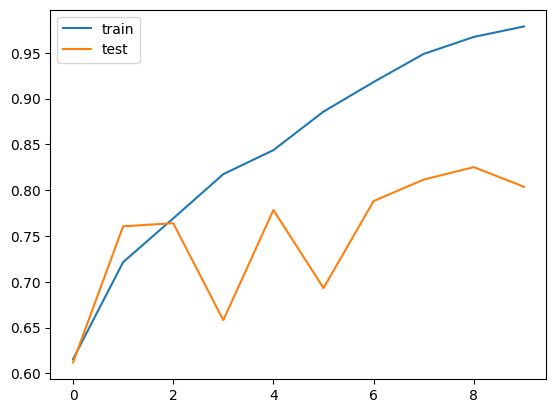

In [13]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'],label='train')
plt.plot(hist.history['val_accuracy'],label='test')
plt.legend()
plt.show()

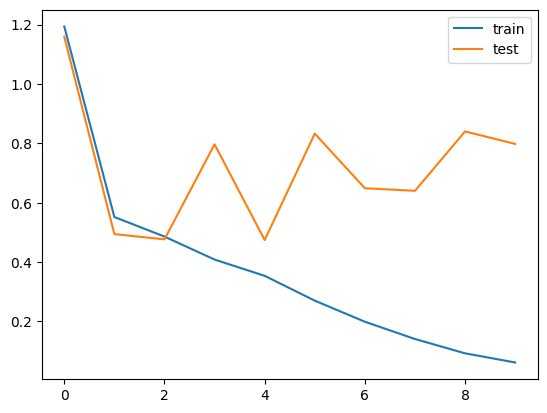

In [14]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'],label='train')
plt.plot(hist.history['val_accuracy'],label='test')
plt.legend()
plt.show()

In [15]:
# Methods to reduce overfitting :
# 1. Data Augmentation
# 2. BatchNormalization
# 3. Dropout, EarlyStopping
# 4. L1/L2 Regularization
# 5. Reduce complexity
# 6. Add more data

img1 (6124, 4082, 3)


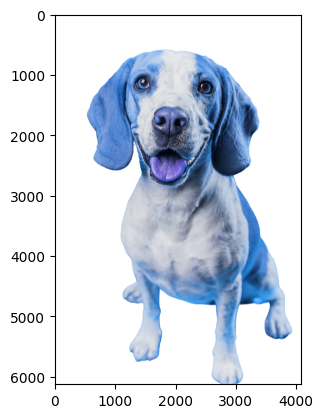

In [21]:
import cv2
test_img_1=cv2.imread('/content/dog.jpg')
plt.imshow(test_img_1)
print("img1",test_img_1.shape)

img2 (360, 540, 3)


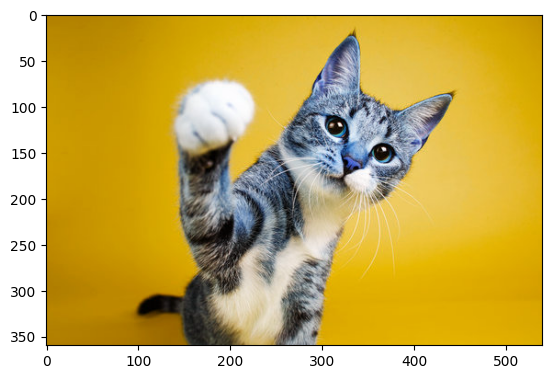

In [22]:
test_img_2=cv2.imread('/content/cat.jpg')
plt.imshow(test_img_2)
print("img2",test_img_2.shape)

In [23]:
# Resize the image to the desired dimensions
test_img_1 = cv2.resize(test_img_1, (256, 256))
test_input_1 = test_img_1.reshape((1,256,256,3))
print(model.predict(test_input_1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[1.]]


In [37]:
# Poor performance
test_img_2 = cv2.resize(test_img_2, (256, 256))
test_input_2 = test_img_2.reshape((1,256,256,3))
print(model.predict(test_input_2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[0.]]


In [25]:
# 1. [Batch Norm, Dropout] accuracy: 0.9486 - loss: 0.1344 - val_accuracy: 0.8202 - val_loss: 0.6937
# 2. [Batch Norm, Dropout, Early stopping] accuracy: 0.9802 - loss: 0.0586 - val_accuracy: 0.8234 - val_loss: 0.8932
# 3. [           [same]                  ] accuracy: 0.9609 - loss: 0.1116 - val_accuracy: 0.8200 - val_loss: 0.9124

## Data Augmentation

In [26]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [27]:
batch_size = 16
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    '/content/test',
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [28]:
model = Sequential()

model.add((Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3))))
model.add((MaxPooling2D(pool_size=(2,2),strides=2,padding='valid')))

model.add((Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu')))
model.add((MaxPooling2D(pool_size=(2,2),strides=2,padding='valid')))

model.add((Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu')))
model.add((MaxPooling2D(pool_size=(2,2),strides=2,padding='valid')))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [33]:
history = model.fit(train_generator,
          steps_per_epoch=1000, # batch size
          epochs=20,validation_data=validation_generator,
          validation_steps=800) # batch size

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 247s 247ms/step - accuracy: 0.6729 - loss: 0.6118 - val_accuracy: 0.7428 - val_loss: 0.5477
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.7170 - loss: 0.5602 - val_accuracy: 0.7024 - val_loss: 0.5748
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 254s 249ms/step - accuracy: 0.7345 - loss: 0.5323 - val_accuracy: 0.7592 - val_loss: 0.5072
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 70s 70ms/step - accuracy: 0.7590 - loss: 0.5007 - val_accuracy: 0.7394 - val_loss: 0.5258
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 249s 249ms/step - accuracy: 0.7832 - loss: 0.4626 - val_accuracy: 0.7952 - val_loss: 0.4398
Epoch 6/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 71ms/step - accuracy: 0.7936 - loss: 0.4385 - val_accuracy: 0.8024 - val_loss: 0.4300
Epoch 7/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 256s 254ms/step - accuracy: 0.8035 - loss: 0.4332 - val_accuracy: 0.8100 - val_loss: 0.4123
Epoch 8/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 74s 74ms/step - accuracy: 

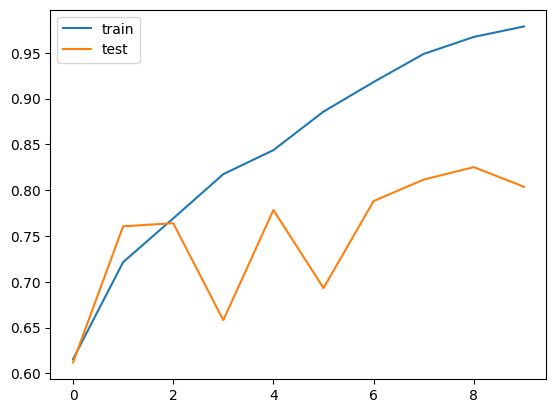

In [34]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'],label='train')
plt.plot(hist.history['val_accuracy'],label='test')
plt.legend()
plt.show()

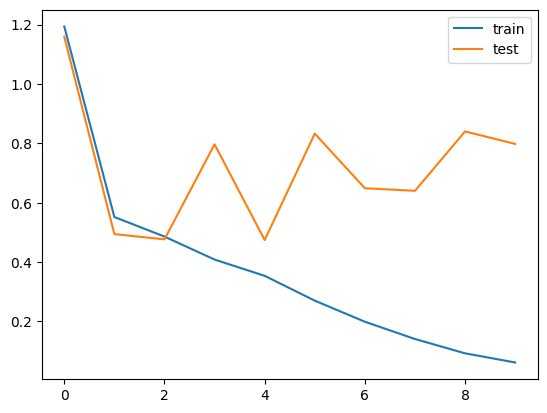

In [35]:
plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'],label='test')
plt.legend()
plt.show()

In [36]:
print(model.predict(test_input_1))
print(model.predict(test_input_2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
[[1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.]]
